# Prosper loans dataset Investigation
## by Abdelhamid Khamis

## Investigation Overview

>I sought to find out two things during this investigation:
<ul>
    <li>The variables that can be employed to predict credit default.</li>
    <li>What elements have an impact on Prosper's rating?</li>
</ul>

## Dataset Overview

>This dataset contains data about Prosper, a credit company that facilitates peer-to-peer lending. There are 113,937 loans in total, with 81 different variables. I've used the following factors to conduct my investigation: Term, LoanStatus, BorrowerRate, ProsperRating (Alpha), ListingCategory (numeric), EmploymentStatus, DelinquenciesLast7Years, StatedMonthlyIncome, TotalProsperLoans, LoanOriginalAmount, LoanOriginationDate, Recommendations, and Investors are some of the terms used by Prosper.

In [23]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [24]:
# load in the dataset into a pandas dataframe
df = pd.read_csv('prosperLoanData.csv')

In [25]:
# setting default color
default_color = sb.color_palette('muted')[4]
# getting rid of scientific notation
pd.options.display.float_format = '{:.2f}'.format

## Wrangling
There were three key data issues:
<ol>
    <li>Since 2009, Prosper has been using the Prosper grading system. Credit Grade was used by Prosper before to 2009. Pre-2009 data points had to be completely removed.</li>
    <li>The majority of the loans in the dataset are current loans, hence they cannot be used to predict credit default. Chargedoff and defaulted credits were the two types of defaulted credits (see sub-slide).To fix this, I deleted all existing loans and combined chargedoff and defaulted credits.</li>
    <li>The number of outliers in stated monthly income was exceptionally high, with a wide range of numbers from 0 to 1750000. To remedy this, I removed all data that was more than three standard deviations away from the mean.</li>
</ol>

In [26]:
# droping pre-2009 data
target_df = df.dropna(subset=['ProsperRating (Alpha)']).reset_index()

In [27]:
target_df['StatedMonthlyIncome'].describe()

count     84853.00
mean       5931.17
std        8239.94
min           0.00
25%        3434.00
50%        5000.00
75%        7083.33
max     1750002.92
Name: StatedMonthlyIncome, dtype: float64

In [28]:
income_std = target_df['StatedMonthlyIncome'].std()
income_mean = target_df['StatedMonthlyIncome'].mean()
boundary = income_mean + income_std * 3
boundary

30651.006023351034

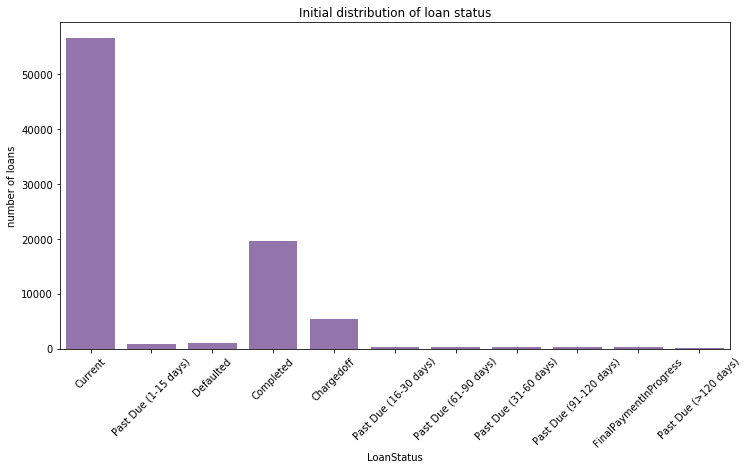

In [29]:
plt.figure(figsize=[12, 6])
plt.xticks(rotation=45)
plt.title('Initial distribution of loan status')
sb.countplot(data = target_df, x = 'LoanStatus', color = default_color)
plt.ylabel('number of loans');

In [30]:
# leaving only completed chargedoff or defaulted listings
condition = (target_df['LoanStatus'] == 'Completed') | (target_df['LoanStatus'] == 'Defaulted') | (target_df['LoanStatus'] == 'Chargedoff')
target_df = target_df[condition]

# setting chargedoff as defaulted
def change_to_defaulted(row):
    if row['LoanStatus'] == 'Chargedoff':
        return 'Defaulted'
    else:
        return row['LoanStatus']

target_df['LoanStatus'] = target_df.apply(change_to_defaulted, axis=1)

There are 26005 loans in the data set after wrangling: 19664 completed loans and 6341 defaulted loans.

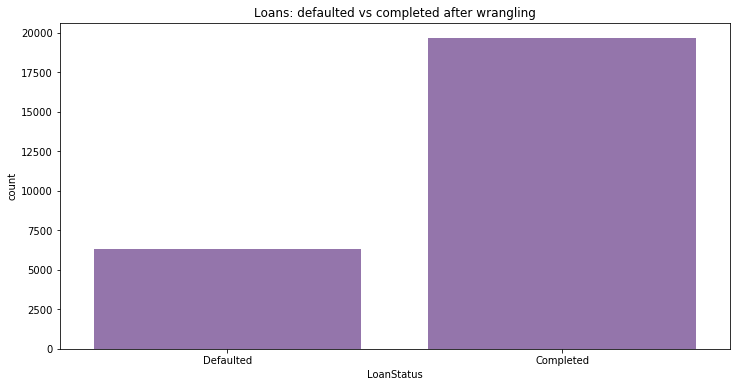

In [31]:
plt.figure(figsize=[12, 6])
plt.title('Loans: defaulted vs completed after wrangling')
sb.countplot(data = target_df, x = 'LoanStatus', color = default_color);

In [32]:
# Removing outliers from income column
target_df = target_df[target_df['StatedMonthlyIncome'] < boundary]

The Monthly Income Distribution looks to be about normal after some wrangling, with a high right skew and a mean of 5328 USD and a maximum value of 30416.67 USD.

In [33]:
target_df['StatedMonthlyIncome'].describe()

count   25938.00
mean     5328.39
std      3390.76
min         0.00
25%      3166.67
50%      4583.33
75%      6666.67
max     30416.67
Name: StatedMonthlyIncome, dtype: float64

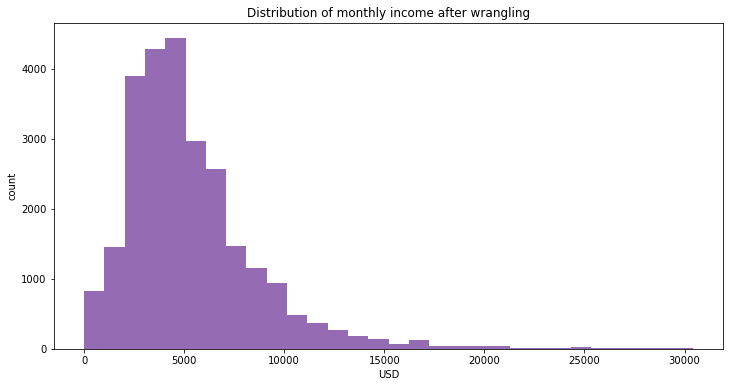

In [34]:
plt.figure(figsize=[12, 6])
plt.title('Distribution of monthly income after wrangling')
plt.ylabel('count')
plt.xlabel('USD')
plt.hist(data=target_df, x='StatedMonthlyIncome', bins=30, color=default_color);

ProsperRating is an ordinal categorical variable with the values ('AA', 'A', 'B', 'C', 'D', 'E', 'HR') from higher to lower. In the data set, ratings have a nearly normal distribution, with the highest 'AA' and lowest 'HR' ratings having the fewest occurrences.

In [35]:
ordinal_list = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_list)
df['ProsperRating (Alpha)'] = df['ProsperRating (Alpha)'].astype(ordered_var)

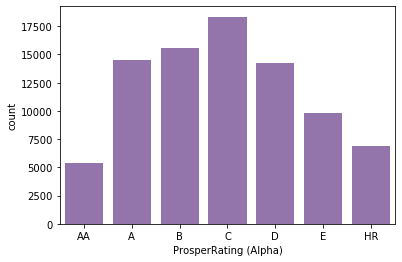

In [36]:
sb.countplot(data=df, x='ProsperRating (Alpha)', color=default_color);

In [37]:
# wrangling categorical variables
ordinal_list = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']
ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_list)
target_df['ProsperRating (Alpha)'] = target_df['ProsperRating (Alpha)'].astype(ordered_var)

categories = {1: 'Debt Consolidation', 2: 'Home Improvement', 3: 'Business', 6: 'Auto', 7: 'Other'}
def reduce_categories(row):
    loan_category = row['ListingCategory (numeric)']
    if  loan_category in categories:
        return categories[loan_category]
    else:
        return categories[7]

target_df['ListingCategory (numeric)'] = target_df.apply(reduce_categories, axis=1)

With the exception of rating D, which turns out to be the most prevalent rating among defaulted credits, the general pattern is that the lower the Prosper rating, the more defaults on credits.

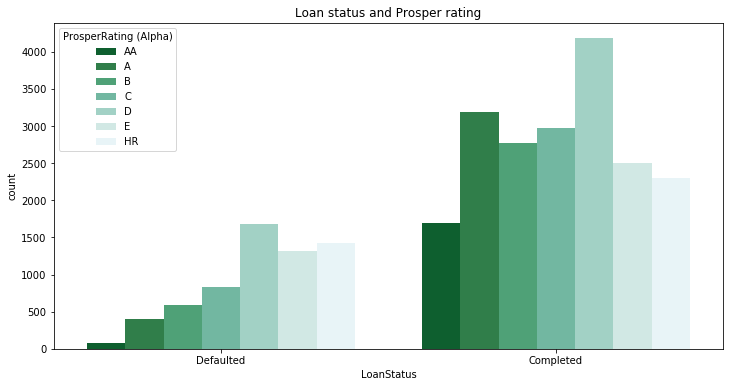

In [38]:
plt.figure(figsize=[12, 6])
plt.title('Loan status and Prosper rating')
sb.countplot(data=target_df, x='LoanStatus', hue='ProsperRating (Alpha)', palette='BuGn_r');

Individuals with employment status 'Not employed' or 'Self-employed' are more prone to default on credit:

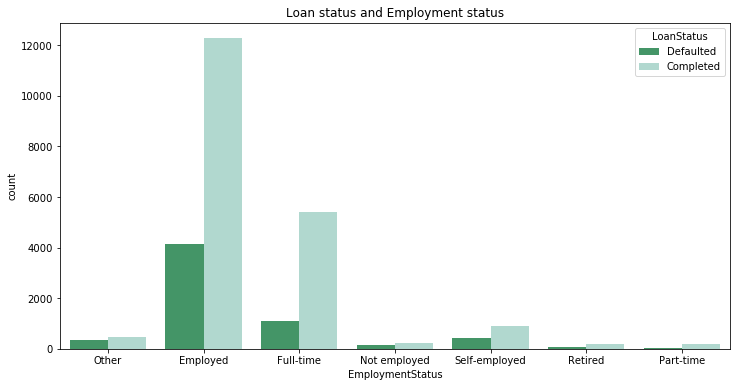

In [39]:
plt.figure(figsize = [12, 6])
plt.title('Loan status and Employment status')
sb.countplot(data=target_df, x='EmploymentStatus', hue='LoanStatus', palette='BuGn_r');

Long-term (60-month) credit has the highest percentage of defaulted credits.

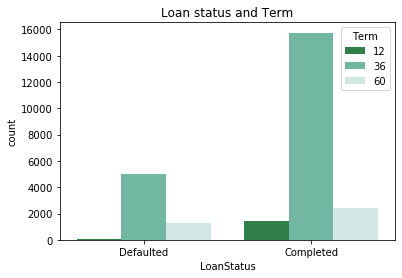

In [40]:
plt.title('Loan status and Term')
sb.countplot(data=target_df, x='LoanStatus', hue='Term', palette='BuGn_r');

Borrowers with a high Prosper rating tend to borrow more, and defaulted loans for high-rated borrowers are greater than completed loans. Borrowers with a poor credit rating, on the other hand, tend to borrow less and have more defaulted credits than completed.

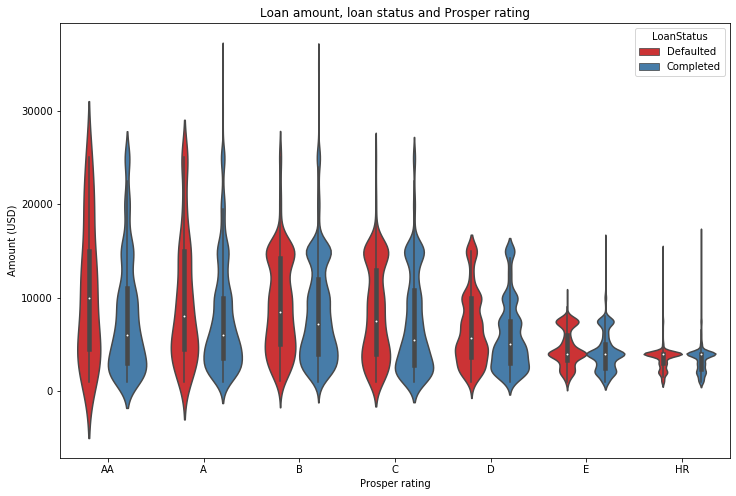

In [41]:
plt.figure(figsize = [12, 8])
plt.title('Loan amount, loan status and Prosper rating')
sb.violinplot(data=target_df, x='ProsperRating (Alpha)', y='LoanOriginalAmount', hue='LoanStatus', palette="Set1")
plt.xlabel('Prosper rating')
plt.ylabel('Amount (USD)');

Business and Home Improvement categories proved to be riskier than others.

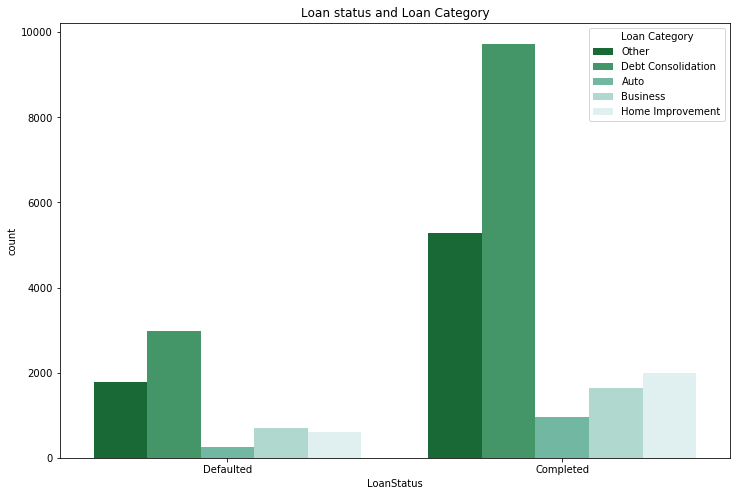

In [42]:
plt.figure(figsize = [12, 8])
plt.title('Loan status and Loan Category')
g = sb.countplot(data=target_df, x='LoanStatus', hue='ListingCategory (numeric)', palette='BuGn_r')
g.legend_.set_title('Loan Category')

Individuals with high rating tend to have higher monthly income.

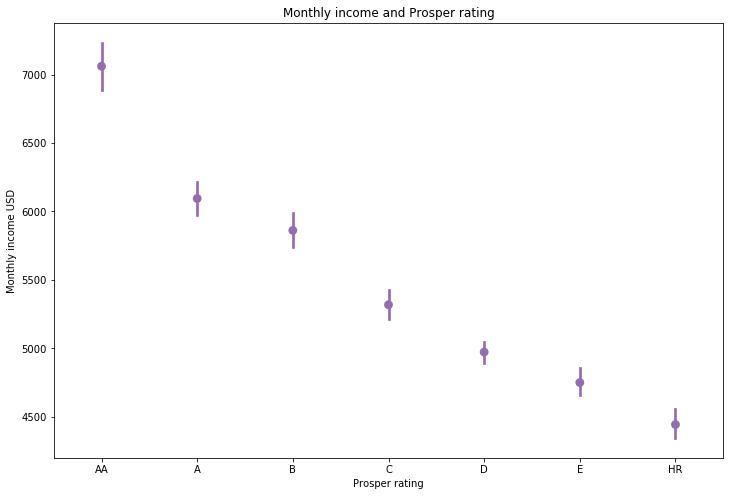

In [43]:
plt.figure(figsize = [12, 8])
plt.title('Monthly income and Prosper rating')
sb.pointplot(data = target_df, x = 'ProsperRating (Alpha)', y = 'StatedMonthlyIncome', linestyles = '', color = default_color)
plt.xlabel('Prosper rating')
plt.ylabel('Monthly income USD');

The proportion of people with the employment classifications 'Not employed,' 'Self-employed,' and 'Retired' rises as the Prosper rating falls.

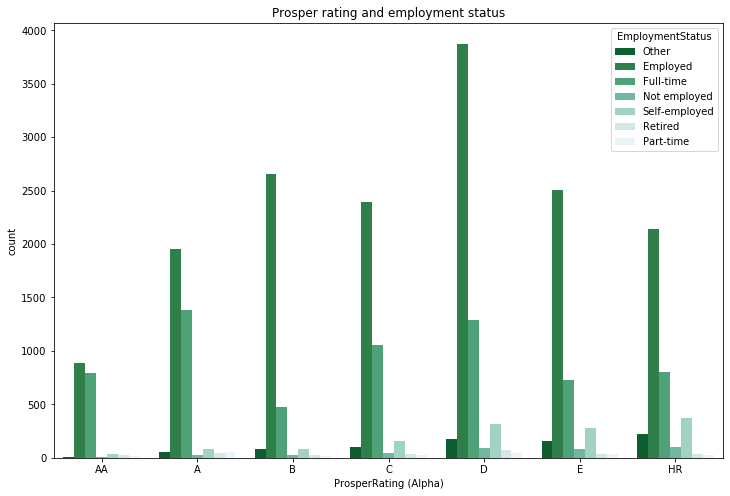

In [44]:
plt.figure(figsize = [12, 8])
plt.title('Prosper rating and employment status')
sb.countplot(data = target_df, x = 'ProsperRating (Alpha)', hue = 'EmploymentStatus', palette='BuGn_r');

In [ ]:
!jupyter nbconvert slides_deck.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook slides_deck.ipynb to slides
[NbConvertApp] Writing 852557 bytes to slides_deck.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Serving your slides at http://127.0.0.1:8000/slides_deck.slides.html
Use Control-C to stop this server
[NbConvertApp] WARNING | No web browser found: could not locate runnable browser.
